<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Introduction to Gridsearching Hyperparameters

_Authors: Kiefer Katovich (SF), David Yerrington (SF)_

---

![](https://snag.gy/aYcCt2.jpg)

### Learning Objective
- Describe what the terms gridsearch and hyperparameter mean.
- Build a gridsearching procedure from scratch.
- Apply sklearn's `GridSearchCV` object with basketball data to optimize a KNN model.
- Use and evaluate attributes of the gridsearch object.
- Describe the pitfalls of searching large hyperparameter spaces.

### Lesson Guide
- [What is "grid searching"? What are "hyperparameters"?](#intro)
- [Basketball Data](#basketball-data)
- [Fitting a Default KNN](#fit-knn)
- [Searching for the Best Hyperparameters](#searching)
    - [Grid Search Pseudocode](#pseudocode)
    - [Using `GridSearchCV`](#gscv)
- [A Caution on Grid Searching](#caution)
- [Independent Practice: Grid Searching Regularization Penalties with Logistic Regression](#practice)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id='intro'></a>

## What is "Grid Searching"? What are "Hyperparameters"?

---

Models often have built-in specifications that we can use to fine-tune our results. For example, when we choose a linear regression, we may decide to add a penalty to the loss function such as the Ridge or the Lasso. Those penalties require the regularization strength, alpha, to be set. 

**These specifications are called hyperparameters.**

Hyperparameters are different from the parameters of the model that result from a fit, such as the coefficients. They are set prior to the fit - usually when we instantiate it - and they affect or determine the model's behavior.

There are often more than one kind of hyperparamter to set for a model. For example, in the KNN algorithm, we have a hyperparameter to set the number of neighbors. We also have a hyperparameter to set the weights, eithe uniform or distance. Generally, we want to know the *optimal* hyperparameter settings, the set that results in the best model evaluation. 

**The search for the optimal set of hyperparameters is called gridsearching.**

Gridsearching gets its name from the fact that we are searching over a "grid" of parameters. For example, imagine the `n_neighbors` hyperparameters on the x-axis and `weights` on the y-axis, and we need to test all points on the grid.

**Gridsearching uses cross-validation internally to evaluate the performance of each set of hyperparameters.** More on this later.

<a id='basketball-data'></a>

## Basketball Data

---

To explore the process of gridsearching over sets of hyperparameters, we will use some basketball data. The data below has statistics for 4 different seasons of NBA basketball: 2013-2016.
- This data includes aggregate statistical data for each game. 
- The data of each game is aggregated by match for all players.
- Scraped from http://www.basketball-reference.com

Many of the columns in the dataset represent the mean of a statistic across the last 10 games, for example. Non-target statistics are for *prior* games, they do not include information about player performance in the current game.

**We are interested in predicting whether the home team will win the game or not.** This is a classification problem.


### Load the data and create the target and predictor matrix
- The target will be a binary column of whether the home team wins.
- The predictors should be numeric statistics columns.

Exclude these columns from the predictor matrix:

    ['GameId','GameDate','GameTime','HostName',
     'GuestName','total_score','total_line','game_line',
     'winner','loser','host_win_count','Season']


In [4]:
data = pd.read_csv('./datasets/basketball_data.csv')

In [5]:
# A:
data
data['win'] = np.where(data['HostName']==data['winner'],1,0)

### Create the training and testing data
- Test data should be the 2016 season data, training data will be the previous seasons.
- Make sure to standardize your predictor matrix (easiest to do prior to splitting the data into training and testing)

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train = X[data.Season.isin([2013,2014,2015])]
X_test = X[data.Season.isin([2016])]
y_train = y[data.Season.isin([2013,2014,2015])]
y_test = y[data.Season.isin([2016])]
# or...
# X_test = data[data.Season==2016]

In [8]:
X_train = X_train.drop(['GameId','GameDate','GameTime','HostName',
 'GuestName','total_score','total_line','game_line',
 'winner','loser','host_win_count','Season'], axis=1)
X_test = X_test.drop(['GameId','GameDate','GameTime','HostName',
 'GuestName','total_score','total_line','game_line',
 'winner','loser','host_win_count','Season'], axis=1)

In [9]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)  #ONLY transform, on test data (using fit from train data)!! DON'T fit from test

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


<a id='fit-knn'></a>

## Fitting the Default KNN

---

Below we can fit a default `KNeighborsClassifier` to predict win vs. not on the training data, then score it on the testing data. 

Remember to compare your score to the baseline accuracy.

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
# A:
print('Baseline (mean) score =',np.mean(y_test))                  #baseline: mean score
knn = KNeighborsClassifier()
knn.fit(X_train_s, y_train)
print('KNN Train score       =',knn.score(X_train_s, y_train))    #knn score on train
print('KNN Test score        =',knn.score(X_test_s, y_test))      #knn score on test

# knn on test, is poorer than mean (doesn't matter if on train, its better than mean). 
# Hence, lets try to tune hyperparameters to improve score on test

Baseline (mean) score = 0.6030456852791878
KNN Train score       = 0.749910168882501
KNN Test score        = 0.5715736040609137


<a id='searching'></a>

## Searching for the Best Hyperparameters

---

Our default KNN performs quite poorly on the test data. But what if we changed the number of neighbors? The weighting? The distance metric?

These are all hyperparameters of the KNN algorithm. How would we do this manually? We would need to evaluate on the training data the set of hyperparameters that perform best, and then use this set of hyperparameters to fit the final model and score on the testing set.

<a id='pseudocode'></a>
### Gridsearch pseudocode for our KNN

```python
accuracies = {}
for k in neighbors_to_test:
    for w in weightings_to_test:
        for d in distance_metrics_to_test:
            hyperparam_set = (k, w, d)
            knn = KNeighborsClassifier(n_neighbors=n, weights=w, metric=d)
            cv_accuracies = cross_val_score(knn, X_train, y_train, cv=5)
            accuracies[hyperparam_set] = np.mean(cv_accuracies)
```

In the pseudocode above, we would find the key in the dictionary (a hyperparameter set) that has the largest value (mean cross-validated accuracy).



<a id='gscv'></a>
### Using `GridSearchCV`

This would be an annoying process to have to do manually. Luckily sklearn comes with a convenience class for performing gridsearch:

```python
from sklearn.model_selection import GridSearchCV
```

The `GridSearchCV` has a handful of important arguments:

| Argument | Description |
| --- | ---|
| **`estimator`** | The sklearn instance of the model to fit on |
| **`param_grid`** | A dictionary where keys are hyperparameters for the model and values are lists of values to test |
| **`cv`** | The number of internal cross-validation folds to run for each set of hyperparameters |
| **`n_jobs`** | How many cores to use on your computer to run the folds (-1 means use all cores) |
| **`verbose`** | How much output to display (0 is none, 1 is limited, 2 is printouts for every internal fit) |


Below is an example for how one might set up the gridsearch for our KNN:

```python
knn_parameters = {
    'n_neighbors':[1,3,5,7,9],
    'weights':['uniform','distance']
}

knn_gridsearcher = GridSearchCV(KNeighborsClassifier(), knn_parameters, verbose=1)
knn_gridsearcher.fit(X_train, y_train)
```

**Try out the sklearn gridsearch below on the training data.**

In [12]:
from sklearn.model_selection import GridSearchCV

In [13]:
# A:
knn_parameters = {'n_neighbors':[1, 50, 80, 100, 200],             #5 
                 'weights':['uniform', 'distance'],                #x 2
                 'n_jobs':[-1]}    #set n_jobs to -1, to utilise ALL cores on your computer. Should do this always!
knn_gridsearcher = GridSearchCV(knn, knn_parameters, verbose=1, n_jobs=-1)    #x default cv of 3. Hence 5x2x3=30 combinations
knn_gridsearcher.fit(X_train_s, y_train)

# here we are running all cores, for the knn, AND the gridsearch. 
# But gridsearch arguably more computationally expensive, so that one defo need to set n_jobs=-1


C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.4s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': [1, 50, 80, 100, 200], 'weights': ['uniform', 'distance'], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

<a id='gs-results'></a>
### Examining the results of the gridsearch

Once the gridsearch has fit (this can take awhile!) we can pull out a variety of information and useful objects from the gridsearch object, stored as attributes:

| Property | Use |
| --- | ---|
| **`results.param_grid`** | Displays parameters searched over. |
| **`results.best_score_`** | Best mean cross-validated score achieved. |
| **`results.best_estimator_`** | Reference to model with best score.  Is usable / callable. |
| **`results.best_params_`** | The parameters that have been found to perform with the best score. |
| **`results.grid_scores_`** | Display score attributes with corresponding parameters. | 

**Print out the best score found in the search.**

In [14]:
# A:
knn_gridsearcher.best_score_ # the shortcut. Gives Mean cross-validated score (Accuracy for knn, NOT R2, R2 is for linreg)
                             # of the best_estimator

0.6273805246137262

**Print out the set of hyperparameters that achieved the best score.**

In [15]:
# A:
knn_gridsearcher.best_params_   # Parameter setting that gave the best results on the hold out data.

{'n_jobs': -1, 'n_neighbors': 200, 'weights': 'uniform'}

In [16]:
# to see ALL results
knn_gridsearcher.cv_results_

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\utils\de

{'mean_fit_time': array([0.01529034, 0.01662223, 0.01829457, 0.02127687, 0.05418809,
        0.02692763, 0.01529137, 0.04421488, 0.02692763, 0.04055794]),
 'std_fit_time': array([0.00308254, 0.00339075, 0.00515844, 0.00169564, 0.05547885,
        0.01622512, 0.00046991, 0.02710986, 0.01174413, 0.01178215]),
 'mean_score_time': array([1.35004155, 1.29754202, 1.0032959 , 0.27459796, 0.32346662,
        0.5252618 , 0.50664465, 0.33510375, 0.68051219, 0.43683092]),
 'std_score_time': array([0.02236507, 0.02505752, 0.47557277, 0.00124475, 0.03079629,
        0.08278201, 0.02912274, 0.05080194, 0.16857474, 0.08133021]),
 'param_n_jobs': masked_array(data=[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_n_neighbors': masked_array(data=[1, 1, 50, 50, 80, 80, 100, 100, 200, 200],
              mask=[False, False, False, False, False,

In [17]:
# to see results' dictionary keys (or col headers)
knn_gridsearcher.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_jobs', 'param_n_neighbors', 'param_weights', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

In [18]:
# to see results' 'params'
pd.DataFrame(knn_gridsearcher.cv_results_['params'])

# to see more of the cols that were produced...
model = pd.DataFrame(knn_gridsearcher.cv_results_['params'])
model['mean_test_score'] = knn_gridsearcher.cv_results_['mean_test_score']
model

,n_jobs,n_neighbors,weights,mean_test_score
0,-1,1,uniform,0.547610
1,-1,1,distance,0.547610
2,-1,50,uniform,0.621631
3,-1,50,distance,0.622709
4,-1,80,uniform,0.624147
5,-1,80,distance,0.624147
6,-1,100,uniform,0.623428
7,-1,100,distance,0.623787
8,-1,200,uniform,0.627381
9,-1,200,distance,0.625225


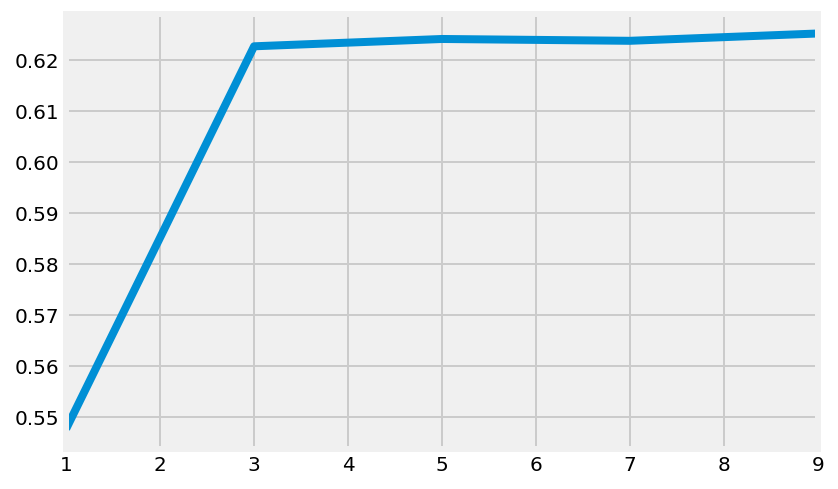

In [19]:
# can also plot the results

# model['mean_test_score'].plot()
model[model['weights']=='distance']['mean_test_score'].plot()

**Assign the best fit model (`best_estimator_`) to a variable and score it on the test data.**

Compare this model to the baseline accuracy and your default KNN.

In [20]:
# A:
knn_optimal = knn_gridsearcher.best_estimator_    # Estimator that was chosen by the search, 
                                    # i.e. estimator which gave highest score (or smallest loss if specified) on the left out data.
knn_optimal.score(X_test_s, y_test)

# knn_optimal score on test data...
# is better than baseline mean (0.603), ALSO better than default knn (0.572)

0.6517766497461929

In [21]:
# compare actual against pred, for 1st few values
print('Actual:     ', y_test.values[:20])
print('Predictions:',knn_optimal.predict(X_test_s)[:20])

Actual:      [1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0]
Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


<a id='caution'></a>

## A Word of Caution on Grid searching

---

Sklearn models often have many options/hyperparameters with many different possible values. It may be tempting to search over a wide variety of them. In general, this is not wise.

Remember that **gridsearch searches over all possible combinations of hyperparamters in the paramter dictionary!**

The KNN model class takes a wider range of options during instantiation than we have explored. Imagine that we had this as our parameter dictionary:

```python
parameter_grid = {
    'n_neighbors':range(1,151),
    'weights':['uniform','distance',custom_function],
    'algorithm':['ball_tree','kd_tree','brute','auto'],
    'leaf_size':range(1,152),
    'metric':['minkowski','euclidean'],
    'p':[1,2]
}
```

**How many different combinations will need to be tested?

| Parameter | Potential Values | Unique Values |
| --- | ---| ---: |
| **n_neighbors** | int range 1-150 | 150 |
| **weights** | strs:  "uniform", "distance" or user defined function | 3 |
| **algorithm** | strs: "ball_tree", "kd_tree", "brute", "auto" | 4 |
| **leaf_size** | int range 1-151 | 151 |
| **metric** | str: "minkowski" or 'euclidean' type | 2 |
| **p** | int: 1=manhattan_distance, 2= euclidean_distance | 2 |
|| <br>_150 \* 3 \* 4 \* 151 \* 2 \* 2 = n combinations_ <br><br>| _1,087,200_ |

Over a million tests *before we even consider the number of cross-validation folds!*

If we're not careful, gridsearching can quickly blow up, taking our time and machine with it. A lot of the hyperparameters we put in the dumb example above are either redundant or not useful.

> **It is extremely important to understand what the hyperparameters do and think critically about what ranges are useful and relevant to your model!**


One way to survey a space of possible parameters without testing every single parameter is to use a randomized search.

In [22]:
from sklearn.model_selection import RandomizedSearchCV

In [26]:
knn_gridsearcher_random = RandomizedSearchCV(knn, knn_parameters, verbose=1, n_jobs=-1)
knn_random_optimal = knn_gridsearcher_random.best_estimator_
knn_random_optimal.score(X_test_s, y_test)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

<a id='practice'></a>

## Practice: Grid Search Regularization Penalties with Logistic Regression

---

Logistic regression models can also apply the Lasso and Ridge penalties. The `LogisticRegression` class takes these regularization-relevant hyperparameters:

| Argument | Description |
| --- | ---|
| **`penalty`** | `'l1'` for Lasso, `'l2'` for Ridge |
| **`solver`** | Must be set to `'liblinear'` for the Lasso penalty to work. |
| **`C`** | The regularization strength. Equivalent to `1./alpha` |

**You should:**
1. Fit and validate the accuracy of a default logistic regression on the basketball data.
- Perform a gridsearch over different regularization strengths and Lasso and Ridge penalties.
- Compare the accuracy on the test set of your optimized logistic regression to the baseline accuracy and the default model.
- Look at the best parameters found. What was chosen? What does this suggest about our data?
- Look at the (non-zero, if Lasso was selected as best) coefficients and associated predictors for your optimized model. What appears to be the most important predictors of winning the game?


In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# A: